In [1]:
import torch
import torchvision
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn, optim
from torchvision import transforms as transforms
from IPython.display import clear_output
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.has_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [3]:
transforms_ = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]
)

cifar_train = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms_
)

cifar_test = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms_
)

train_dataloader = torch.utils.data.DataLoader(
    cifar_train,
    batch_size=128,
    shuffle=True,
    num_workers=4
)

test_dataloader = torch.utils.data.DataLoader(
    cifar_test,
    batch_size=128,
    shuffle=False,
    num_workers=4
)

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


In [4]:
def image_show(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)

  img = img / 2 + 0.5
  np_img = img.numpy()
  if one_channel:
    plt.imshow(np_img, cmap='Greys')
  else:
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

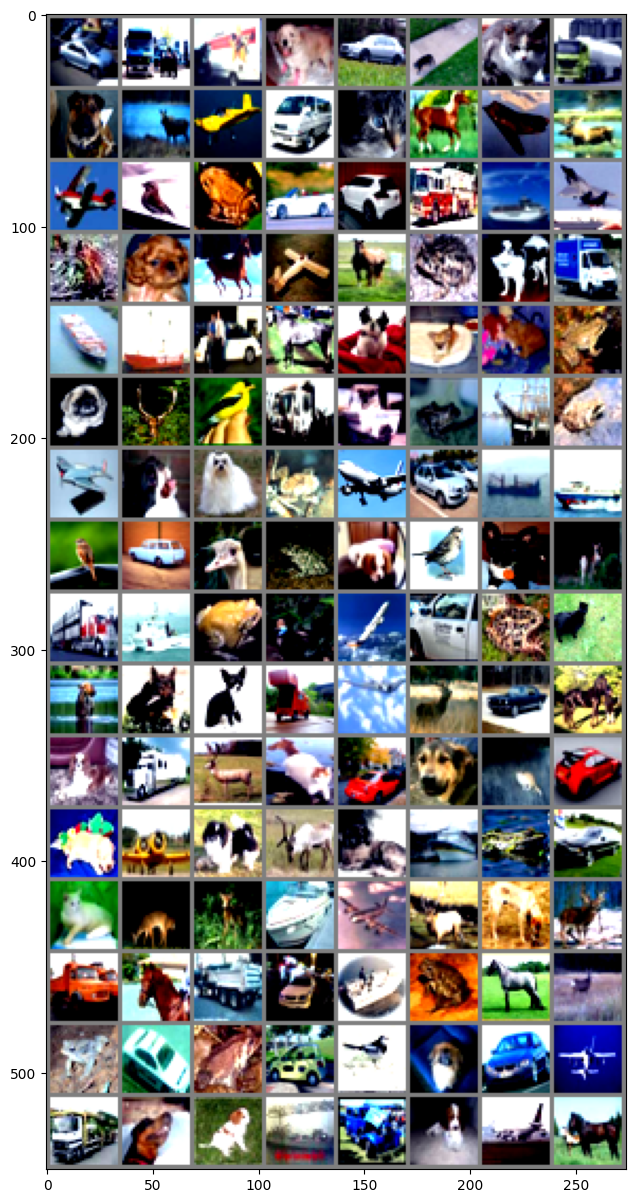

In [5]:
image, label = next(iter(train_dataloader))

img_grid = torchvision.utils.make_grid(image)

plt.figure(figsize=(15, 15))
image_show(img_grid)

In [6]:
def plot_history(train_loss, test_loss, train_acc, test_acc):
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 6), dpi=100)

    plot_params = {
        'linewidth': 2,
        'markersize': 8,
        'alpha': 0.8
    }

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train',
             color='#1f77b4', marker='o', **plot_params)
    plt.plot(test_loss, label='Validation',
             color='#ff7f0e', marker='s', linestyle='--', **plot_params)
    plt.title('Loss Evolution', fontsize=14, pad=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(np.arange(0, len(train_loss)))
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train',
             color='#1f77b4', marker='o', **plot_params)
    plt.plot(test_acc, label='Validation',
             color='#ff7f0e', marker='s', linestyle='--', **plot_params)
    plt.title('Accuracy Evolution', fontsize=14, pad=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(np.arange(0, len(train_acc)))
    plt.ylim(0, 1.05)
    plt.yticks(np.linspace(0, 1, 5))
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


In [7]:
class VGG(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.flatten = nn.Flatten()
    self.fc = nn.Sequential(
        nn.Linear(in_features=16 * 16 * 16, out_features=128),
        nn.LeakyReLU(),
        nn.Linear(in_features=128, out_features=10)
    )

  def forward(self, x):
    x = self.vgg(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x


In [8]:
def train(model, criterion, optimizer, train_loader, val_loader, n_epochs=10):
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, unit="batch", desc=f'Epoch {epoch+1}/{n_epochs} [Train]') as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_size = labels.size(0)
                epoch_train_loss += loss.item() * batch_size
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += batch_size

                pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{correct/total:.3f}"
                })

        train_loss.append(epoch_train_loss / total)
        train_acc.append(correct / total)

        model.eval()
        epoch_val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                batch_size = labels.size(0)
                epoch_val_loss += loss.item() * batch_size
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += batch_size

        val_loss.append(epoch_val_loss / val_total)
        val_acc.append(val_correct / val_total)

        clear_output(wait=True)
        plot_history(train_loss, val_loss, train_acc, val_acc)

        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc[-1]:.4f}")
        print(f" Val Loss: {val_loss[-1]:.4f} |  Val Acc: {val_acc[-1]:.4f}")
        print("-" * 60)

    return model, (train_loss, val_loss, train_acc, val_acc)

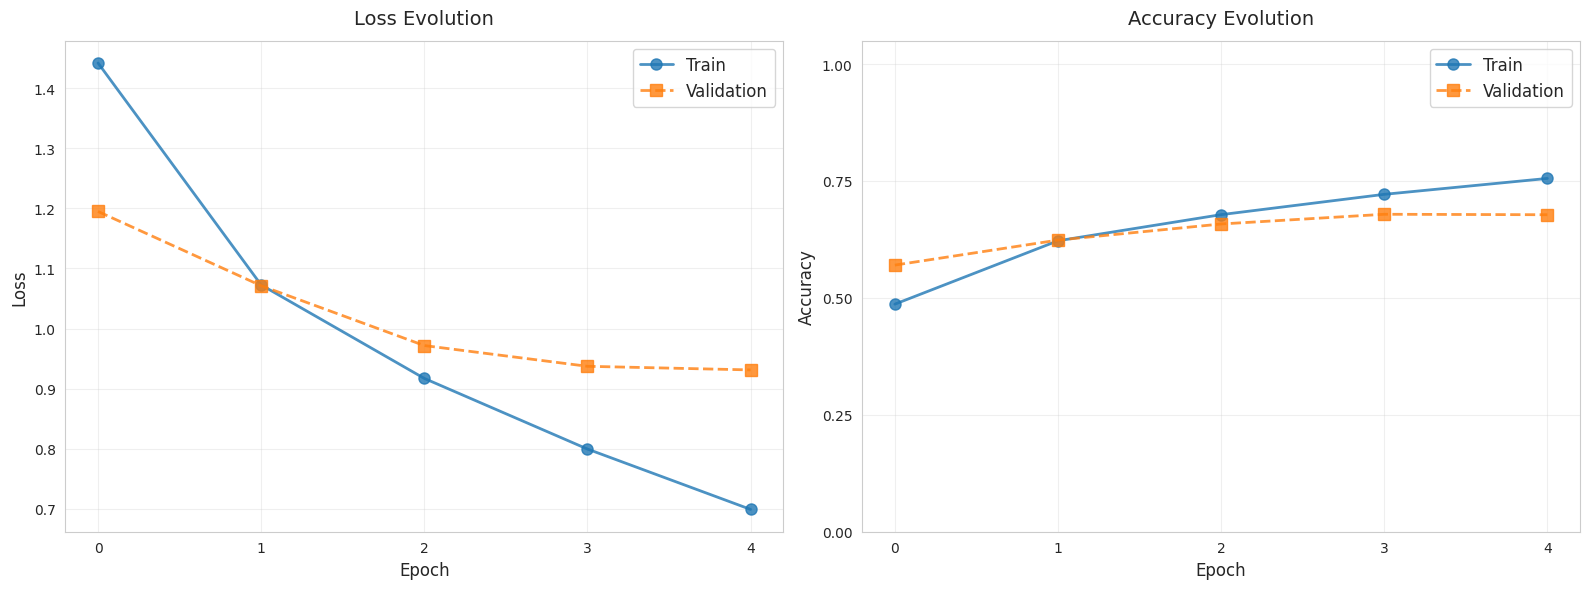

Epoch 5/5
Train Loss: 0.6992 | Train Acc: 0.7554
 Val Loss: 0.9312 |  Val Acc: 0.6778
------------------------------------------------------------


(VGG(
   (vgg): Sequential(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): LeakyReLU(negative_slope=0.01)
     (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): LeakyReLU(negative_slope=0.01)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (fc): Sequential(
     (0): Linear(in_features=4096, out_features=128, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=128, out_features=10, bias=True)
   )
 ),
 ([1.4416001527023314,
   1.0724993884277343,
   0.9170870986747741,
   0.7996274318313599,
   0.6992489647293091],
  [1.1946736274719238,
   1.0711926420211793,
   0.9717051716804505,
   0.9372217830657958,
   0.9311991724014282],
  [0.48658, 0.62212, 0.67798, 0.72142, 0.75544],
  [0.5701, 0.6236, 0.658, 0.6788, 0.6778]))

In [10]:
model = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

md, history = train(model, criterion, optimizer, train_dataloader, test_dataloader, n_epochs=5)

md, history

In [11]:
import PIL

transforms_ = transforms.Compose(
    [
    transforms.ColorJitter(hue=0.05, saturation=0.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]
)

base_transforms = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]
)

cifar_train = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms_
)

cifar_val = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=base_transforms
)

train_dataloader = torch.utils.data.DataLoader(
    cifar_train,
    batch_size=128,
    shuffle=True,
    num_workers=4
)

val_dataloader = torch.utils.data.DataLoader(
    cifar_val,
    batch_size=128,
    shuffle=False,
    num_workers=4
)

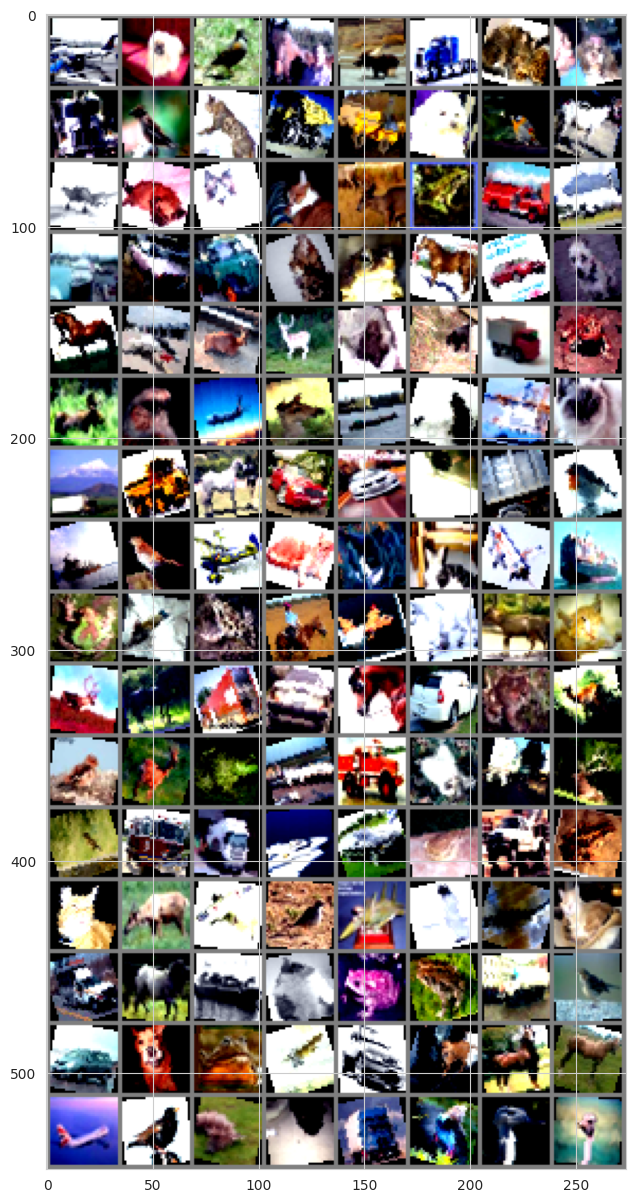

In [12]:
image, label = next(iter(train_dataloader))

img_grid = torchvision.utils.make_grid(image)

plt.figure(figsize=(15, 15))
image_show(img_grid)

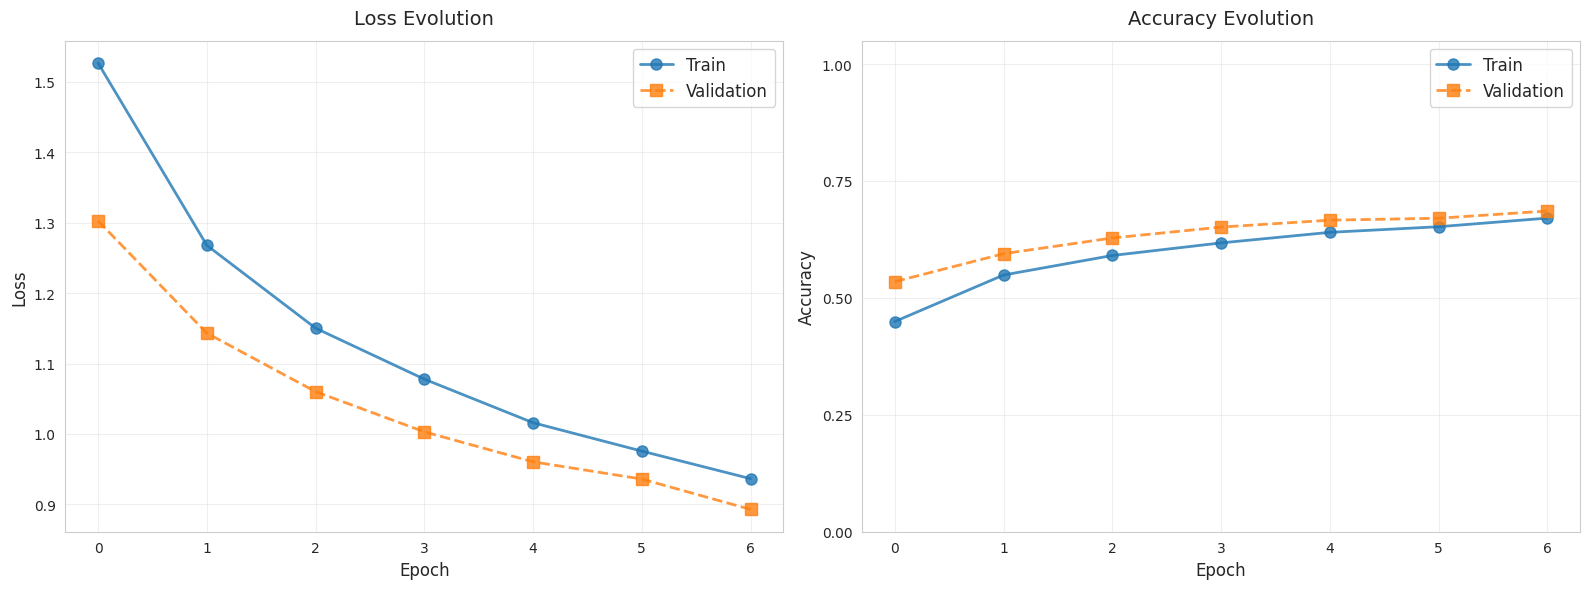

Epoch 7/7
Train Loss: 0.9365 | Train Acc: 0.6706
 Val Loss: 0.8929 |  Val Acc: 0.6858
------------------------------------------------------------


(VGG(
   (vgg): Sequential(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): LeakyReLU(negative_slope=0.01)
     (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): LeakyReLU(negative_slope=0.01)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (fc): Sequential(
     (0): Linear(in_features=4096, out_features=128, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=128, out_features=10, bias=True)
   )
 ),
 ([1.5269060018539429,
   1.2680151264190673,
   1.150321283607483,
   1.077880451927185,
   1.0159926319503785,
   0.9756753200531005,
   0.9365090405273437],
  [1.3027614387512207,
   1.143256014251709,
   1.0601563854217528,
   1.0030627568244934,
   0.9604543724060058,
   0.9359605129241944,
   0.8928803694725037],
  [0.44946, 0.54892, 0.59066, 0.61758, 0.64016, 0.65216, 0.67062],
  [0.5347, 0.5945

In [14]:
model = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, criterion, optimizer, train_dataloader, test_dataloader, n_epochs=7)